House Price Prediction with Linear Regression

1- Pre-processing işlemleri
- Veri görselleştirme
- Kayıp verilerin kontrol edilmesi işlemleri
- Özellik normalizasyon işlemleri (StandardScaler, MinMaxScaler)

2- Validation setinin hazırlanması

3- Modelin oluşturulması
- Test setinin ayrılması
- Lineer regresyon modelinin eğitim setine fit edilmesi

4- Metrikleri kullanarak model performansının belirlenmesi
- r2 variance score
- mean squared error

5- Tahminlerin oluşturulması
- Modelin performansının validation setine göre test edilmesi
- Model performansının belirlenmesi
- Test setine göre tahminlerin yapılması
- DataFrame olarak (to_csv) kaydedilmesi ve görselleştirme işlemleri

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import os
print(os.listdir("../input"))
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

import warnings
warnings.filterwarnings('ignore')

['test.csv', 'train.csv', 'sample_submission.csv', 'data_description.txt']


In [2]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


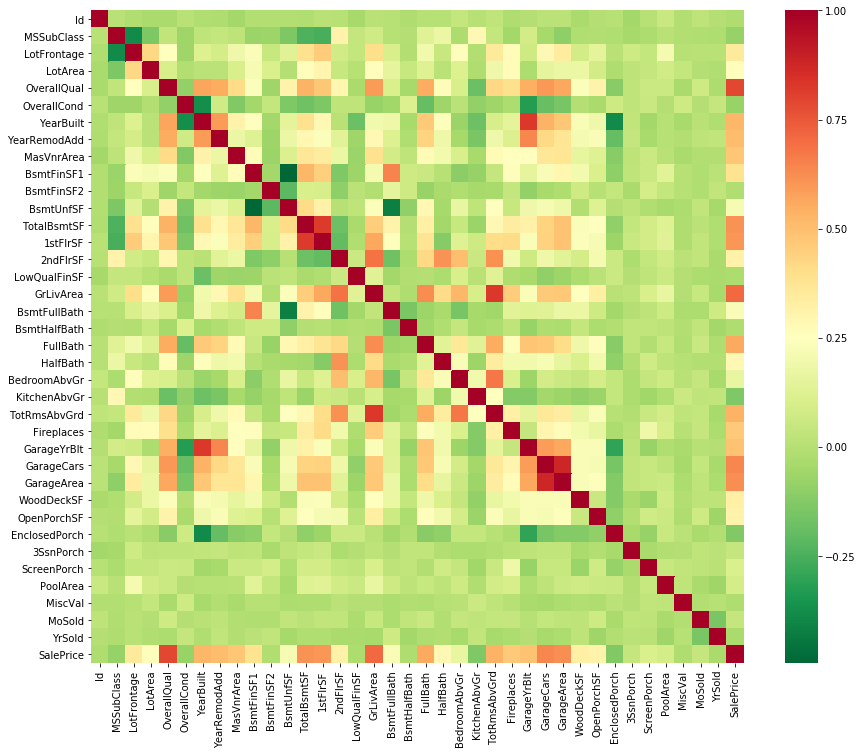

In [3]:
# Veriyi görselleştir - Train setindeki korelasyonun heatmap ile gösterilmesi
corr_matrix = train_df.corr() 
f,ax = plt.subplots(figsize= (15,12))
sns.heatmap(corr_matrix, vmax = 1, square = True, cmap = "RdYlGn_r")

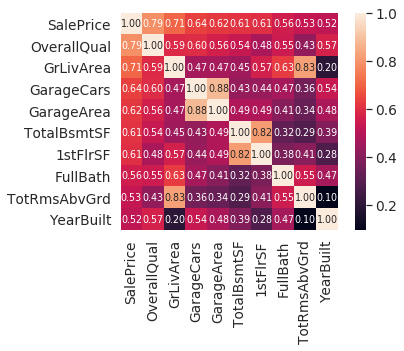

In [4]:
# heatmap'teki ilk 10 değişkenin gösterilmesi
cols = corr_matrix.nlargest(10, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 9.5}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

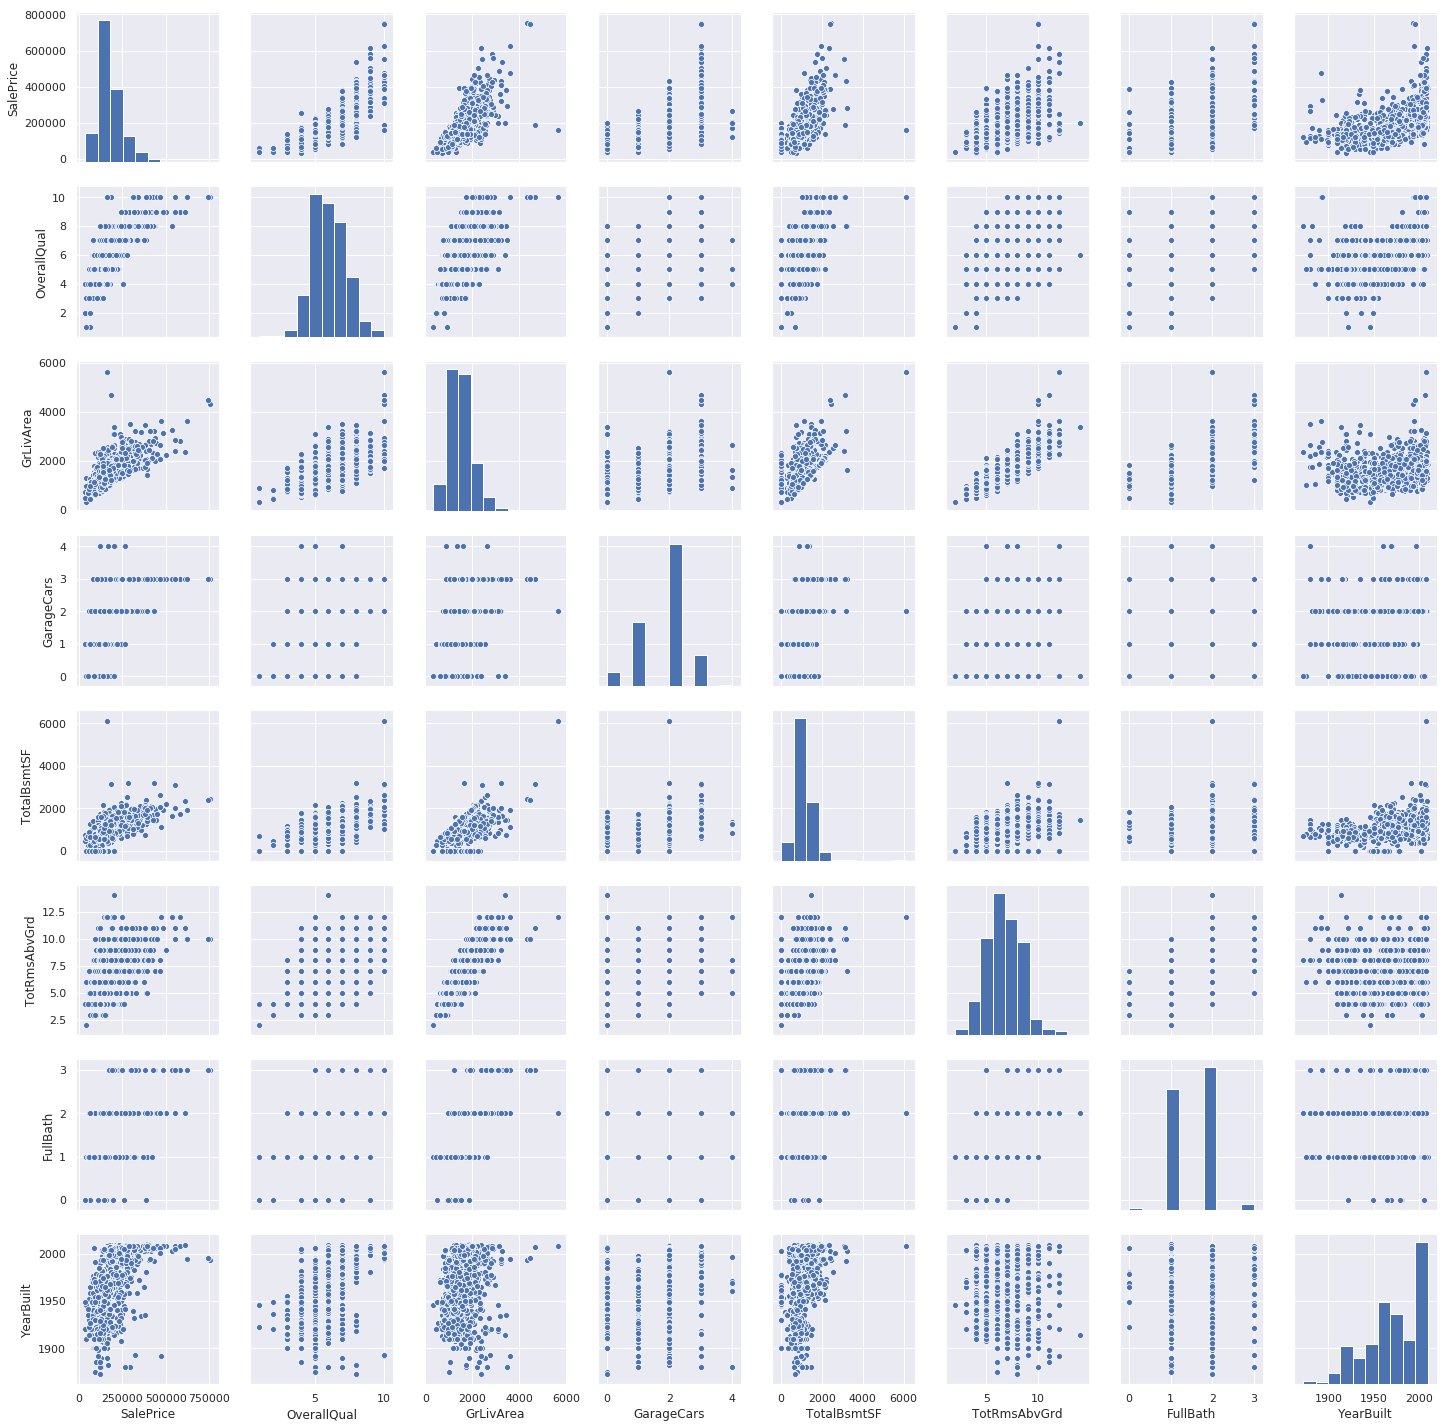

In [5]:
# Scatter plots ile görselleştirme
sns.set()
columns = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'TotRmsAbvGrd', 'FullBath', 'YearBuilt']
sns.pairplot(train_df[columns], height = 2.5)
plt.show()

Electrical       0.068493
MasVnrType       0.547945
MasVnrArea       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
BsmtExposure     2.602740
BsmtFinType2     2.602740
GarageCond       5.547945
GarageQual       5.547945
GarageFinish     5.547945
GarageType       5.547945
GarageYrBlt      5.547945
LotFrontage     17.739726
FireplaceQu     47.260274
Fence           80.753425
Alley           93.767123
MiscFeature     96.301370
PoolQC          99.520548
dtype: float64


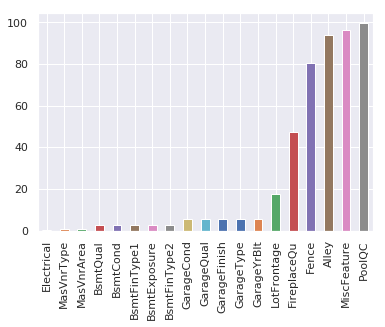

In [6]:
# Kayıp verilerin kontrol edilmesi işlemleri
missing = train_df.isnull().sum()
missing = missing[missing > 0]
percent = ((train_df.isnull().sum())*100/train_df.isnull().count())
percent = percent[percent>0]
missing.sort_values(inplace=True)
percent.sort_values(inplace=True)
missing
print(percent)
percent.plot.bar()

In [7]:
# %15'inden fazlası kayıp olan verilerin çıkarılması
train_df_missing = train_df.copy()
train_df_missing = train_df_missing.drop((percent[percent> 15]).index,1)
print(train_df_missing.shape)
train_df_missing.columns

(1460, 75)


Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'Enclos

In [8]:
# Verinin biçimlendirilmesi
dummy_data = pd.get_dummies(train_df_missing)
dummy_data = dummy_data.select_dtypes(include=[np.number]).interpolate().dropna()
dummy_data_= dummy_data.copy()
data_ = dummy_data_.drop(['SalePrice'], axis=1)

# Verinin biçimlendirilmesi log
dummy_data_['SalePrice'] = np.log(dummy_data_['SalePrice'])
dummy_data_['GrLivArea'] = np.log(dummy_data_['GrLivArea'])
data_['GrLivArea'] = np.log(data_['GrLivArea'])

print("Sale Price olmadan data shape:{}".format(data_.shape))
print("Sale Price ile data shape:{}".format(dummy_data_.shape))


Sale Price olmadan data shape:(1460, 270)
Sale Price ile data shape:(1460, 271)


TotalBsmtSF      0.068540
GarageArea       0.068540
GarageCars       0.068540
KitchenQual      0.068540
BsmtUnfSF        0.068540
BsmtFinSF2       0.068540
BsmtFinSF1       0.068540
SaleType         0.068540
Exterior1st      0.068540
Exterior2nd      0.068540
Functional       0.137080
Utilities        0.137080
BsmtHalfBath     0.137080
BsmtFullBath     0.137080
MSZoning         0.274160
MasVnrArea       1.028101
MasVnrType       1.096642
BsmtFinType2     2.878684
BsmtFinType1     2.878684
BsmtQual         3.015764
BsmtExposure     3.015764
BsmtCond         3.084304
GarageType       5.209047
GarageFinish     5.346127
GarageQual       5.346127
GarageCond       5.346127
GarageYrBlt      5.346127
LotFrontage     15.558602
FireplaceQu     50.034270
Fence           80.123372
Alley           92.666210
MiscFeature     96.504455
PoolQC          99.794380
dtype: float64


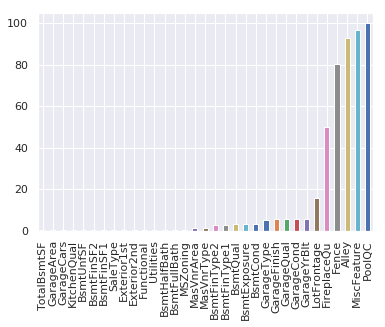

In [9]:
# Validation setinin hazırlanması

# Kayıp verilerin kontrol edilmesi
test_df_ = test_df.copy()
tmissing = test_df_.isnull().sum()
tmissing = tmissing[tmissing > 0]
tpercent = ((test_df_.isnull().sum())*100/test_df_.isnull().count())
tpercent = tpercent[tpercent>0]
tmissing.sort_values(inplace=True)
tpercent.sort_values(inplace=True)
tmissing
print(tpercent)
tpercent.plot.bar()

# Verilerin %15'inden fazlası kayıp olan sütunların silinmesi
test_df_missing = test_df_.drop((tpercent[tpercent> 15]).index,1)

In [10]:
print("%15'inden fazlası kayıp verilerden oluşan sütunlar silindikten sonra eğitim setinin boyutu {}".format(train_df_missing.shape))
print("%15'inden fazlası kayıp verilerden oluşan sütunlar silindikten sonra validation setinin boyutu {}".format(test_df_missing.shape))

tdummy_data = pd.get_dummies(test_df_missing)
tdata = tdummy_data.select_dtypes(include=[np.number]).interpolate().dropna()
tdata.shape

%15'inden fazlası kayıp verilerden oluşan sütunlar silindikten sonra eğitim setinin boyutu (1460, 75)
%15'inden fazlası kayıp verilerden oluşan sütunlar silindikten sonra validation setinin boyutu (1459, 74)


(1459, 254)

In [11]:
# Data transformation - log işlemi
tdata['GrLivArea'] = np.log(tdata['GrLivArea'])

In [12]:
# Eğitim setinde kullanılan sütunlar
train_col = list(data_.columns)
test_col = list(tdata.columns)
tcol = [i for i in train_col if i in test_col]
TrainData = data_[tcol]
ValidationData = tdata[tcol]
print("İşlenen eğitim verisi boyutu:{}".format(TrainData.shape))
print("İşlenen validation verisi boyutu:{}".format(ValidationData.shape))

İşlenen eğitim verisi boyutu:(1460, 254)
İşlenen validation verisi boyutu:(1459, 254)


In [13]:
# Modelin oluşturulması işlemleri

tsize = 0.3
X_train, X_test, y_train, y_test = train_test_split(TrainData, dummy_data_.SalePrice, test_size=tsize, random_state=42)
# Number of training features
n_samples, n_features = X_train.shape

print("Toplam training Samples {}: {}".format((1 - tsize), n_samples))
print("Toplam features: {}".format(n_features))
print("Toplam test samples {}: {}".format((tsize),X_test.shape[0]))

pipeline = Pipeline([('normalizer', StandardScaler()), # Adım 1 - Veriyi normalise et
                     ('clf', LinearRegression(normalize=True)) # Adım 2 - Classifier
                    ])

clfs = LinearRegression(normalize=True)
pipeline.set_params(clf = clfs)
scores = cross_validate(pipeline, X_train, y_train, cv=3, return_train_score = True)
print('---------------------------------')
print(str(clfs))
print('-----------------------------------')
for key, values in scores.items():
    print(key,' mean ', values.mean())
    print(key,' std ', values.std())

Toplam training Samples 0.7: 1022
Toplam features: 254
Toplam test samples 0.3: 438
---------------------------------
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
-----------------------------------
fit_time  mean  0.04088942209879557
fit_time  std  0.006758771843152549
score_time  mean  0.009774525960286459
score_time  std  0.00036986913094167346
test_score  mean  -1.515444654399527e+21
test_score  std  1.1658286775548342e+21
train_score  mean  0.9547659162737253
train_score  std  0.005046954254688861


Variance score: 0.89
Mean squared error: 0.02


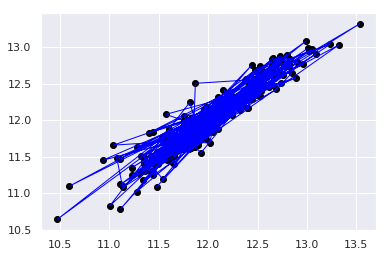

In [14]:
# Model performansının variance score ve mean squared error metrikleri ile belirlenmesi
linearmodel = LinearRegression().fit(X_train,y_train)
y_pred = linearmodel.predict(X_test)
print('Variance score: %.2f' % r2_score(y_test, y_pred))
print("Mean squared error: %.2f"% mean_squared_error(y_test, y_pred))

# Plot çıktısı
plt.scatter(y_test, y_pred,  color='black')
plt.plot(y_test, y_pred, color='blue', linewidth=1)

In [15]:
# Linear regresyon modeli sonuçları ilk 5 satır
result = X_test.copy()
result['Log SalePrice Prediction'] = y_pred
result['SalePrice Prediction'] = np.exp(y_pred)
result['Log SalePrice'] = y_test
result['Real SalePrice'] = np.exp(y_test)
result_show = result[['Id','Log SalePrice','Log SalePrice Prediction','Real SalePrice','SalePrice Prediction']]
result_show.head()

,Id,Log SalePrice,Log SalePrice Prediction,Real SalePrice,SalePrice Prediction
892,893,11.947949,11.925733,154500.0,151105.485893
1105,1106,12.691580,12.758020,325000.0,347326.421201
413,414,11.652687,11.517449,115000.0,100453.336945
522,523,11.976659,12.176826,159000.0,194235.332503
1036,1037,12.661914,12.736576,315500.0,339957.675981


In [16]:
# Tahminlerin oluşturulması
test_y_pred = linearmodel.predict(ValidationData)
test_y_pred

prove = ValidationData.copy()
prove['Log SalePrice Prediction'] = test_y_pred
prove['SalePrice'] = np.exp(test_y_pred)
prove_show = prove[['Id','SalePrice']]
prove_show.head()

,Id,SalePrice
0,1461,113404.792397
1,1462,121346.411329
2,1463,175471.996056
3,1464,191553.303638
4,1465,206830.708426


In [17]:
prove_show.to_csv('results.csv')
# to GitHub; https://github.com/oguzaktas/house-price-prediction